In [34]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
from bbknn import bbknn
import scanorama as scnrma
import pandas as pd
from harmony import harmonize
from sklearn.metrics.cluster import adjusted_rand_score
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
import seaborn as sns
from sklearn.utils import shuffle


import warnings
warnings.filterwarnings("ignore")


from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans



sc.settings.verbosity = 3            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.logging.print_memory_usage()
sc.set_figure_params(dpi=100, dpi_save=200)

scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0
Memory usage: current 12.15 GB, difference +11.89 GB


In [6]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Read in

## Prep

GABA

In [7]:

P28dr_gaba_new = sc.read_h5ad(path_out+'P28dr_gaba_March2021.h5ad')
P28dl_gaba_new = sc.read_h5ad(path_out+'P28dl_gaba_March2021.h5ad')

P38dr_gaba_new = sc.read_h5ad(path_out+'P38dr_gaba_March2021.h5ad')



In [8]:

processed_objs = []
ages = ['P28', 'P38']

for i in range(len(ages)):
    processed_objs.append(sc.read_h5ad(path_in + ages[i] + '_gaba_March.h5ad'))

In [12]:
gaba = P28dr_gaba_new.concatenate(P38dr_gaba_new, P28dl_gaba_new, processed_objs[0], processed_objs[1], 
                                  batch_categories=['P28DR', 'P38DR', 'P28DL', 'P28NR', 'P38NR'])

In [13]:
gaba.obs['Condition'] = gaba.obs['batch']

In [14]:
gaba.obs.Condition.value_counts()

P28DL    2877
P38DR    2362
P28DR    2175
P28NR    2106
P38NR    1619
Name: Condition, dtype: int64

Gluta

In [15]:
DR_h5ads = ['P28/P28_glut_dr_harmony_032921.h5ad', 'P38/P38_glut_dr_harmony_041221.h5ad']

DR_objs = []
for j in DR_h5ads:
    DR_objs.append(sc.read_h5ad(DR_path + j))

P28dl_glut = DL_objs = sc.read_h5ad('P28_glut_dl_harmony_022021.h5ad')

In [17]:
#NR_h5ads = ['P21_glut_12012020.h5ad', 'P28_glut_12012020.h5ad', 'P38_glut_12012020.h5ad']
NR_h5ads = ['P28_glut_03222021.h5ad', 'P38_glut_12012020.h5ad']

NR_objs = []
for i in NR_h5ads:
    NR_objs.append(sc.read_h5ad(NR_path + i))

In [18]:
P28dr_glut = DR_objs[0]
P38dr_glut = DR_objs[1]

P28_glut = NR_objs[0]
P38_glut = NR_objs[1]

In [19]:
gluta = P28dr_glut.concatenate(P38dr_glut, P28dl_glut, P28_glut, P38_glut,
                               batch_categories=['P28DR', 'P38DR', 'P28DL', 'P28NR', 'P38NR'])

In [20]:
gluta.obs['Condition'] = gluta.obs['batch']

In [21]:
gluta.obs.Condition.value_counts()

P38DR    17499
P28DL    17052
P28DR    16379
P28NR    15315
P38NR    10485
Name: Condition, dtype: int64

Non

In [22]:

P28_dr = sc.read_h5ad(in_path + 'P28' + '_non_analyzed_DR.h5ad')
P38_dr = sc.read_h5ad(in_path + 'P38' + '_non_analyzed_DR.h5ad')
P28_dl = sc.read_h5ad(in_path + 'P28' + '_non_analyzed_DL.h5ad')

In [23]:

P28nr = sc.read_h5ad(out_path + 'P28' + '_non_analyzed.h5ad')
P38nr = sc.read_h5ad(out_path + 'P38' + '_non_analyzed.h5ad')

In [24]:
P28_dl.obs['sample'] = P28_dl.obs['batch']

In [25]:
non = P28_dr.concatenate(P38_dr, P28_dl, P28nr, P38nr, 
                         batch_categories=['P28DR', 'P38DR', 'P28DL', 'P28NR', 'P38NR'])

In [26]:
non.obs['Condition'] = non.obs['batch']

In [27]:
non.obs.Condition.value_counts()

P28DL    6646
P28NR    6509
P28DR    6263
P38DR    5810
P38NR    4893
Name: Condition, dtype: int64

## Merge classes

In [28]:
adata = gluta.concatenate(gaba, non, batch_categories=['Excitatory', 'Inhibitory', 'Non-neuron'])

In [29]:
adata.obs['Class'] = adata.obs['batch']

## Re-analyze all together

In [30]:
adata.X = adata.raw.X.A

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs

sc.pp.scale(adata, max_value=10) #scale
sc.tl.pca(adata, svd_solver='arpack') #run PCA


sc.pp.neighbors(adata, n_neighbors=15)


sc.tl.umap(adata)

extracting highly variable genes
    finished (0:00:35)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:30)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:00)


# Plot

## Class, subclass, condition

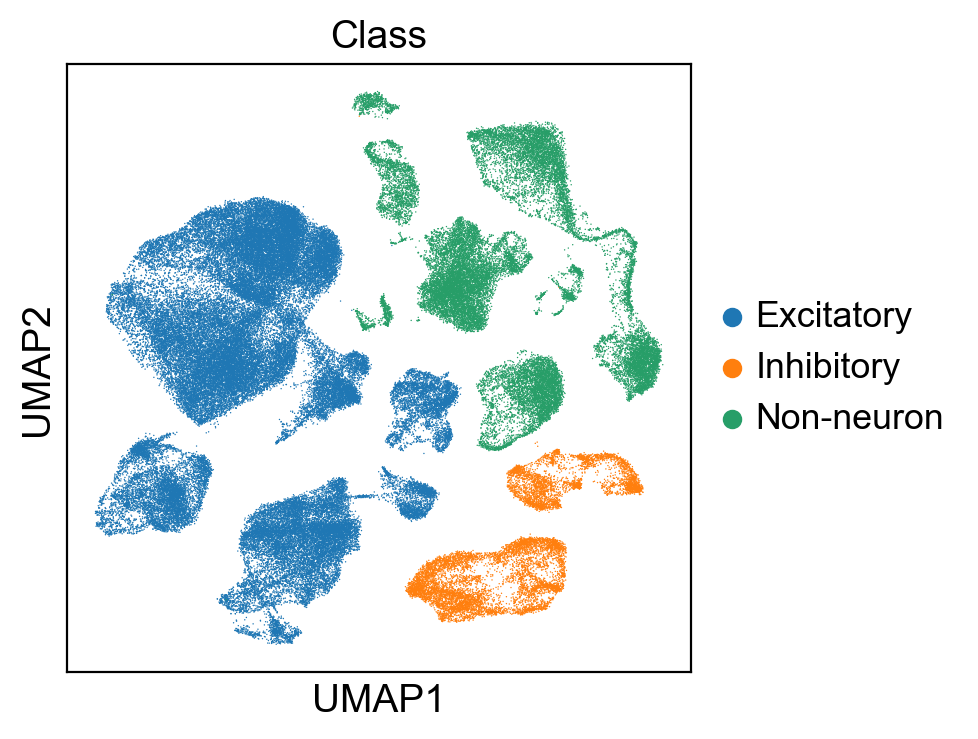

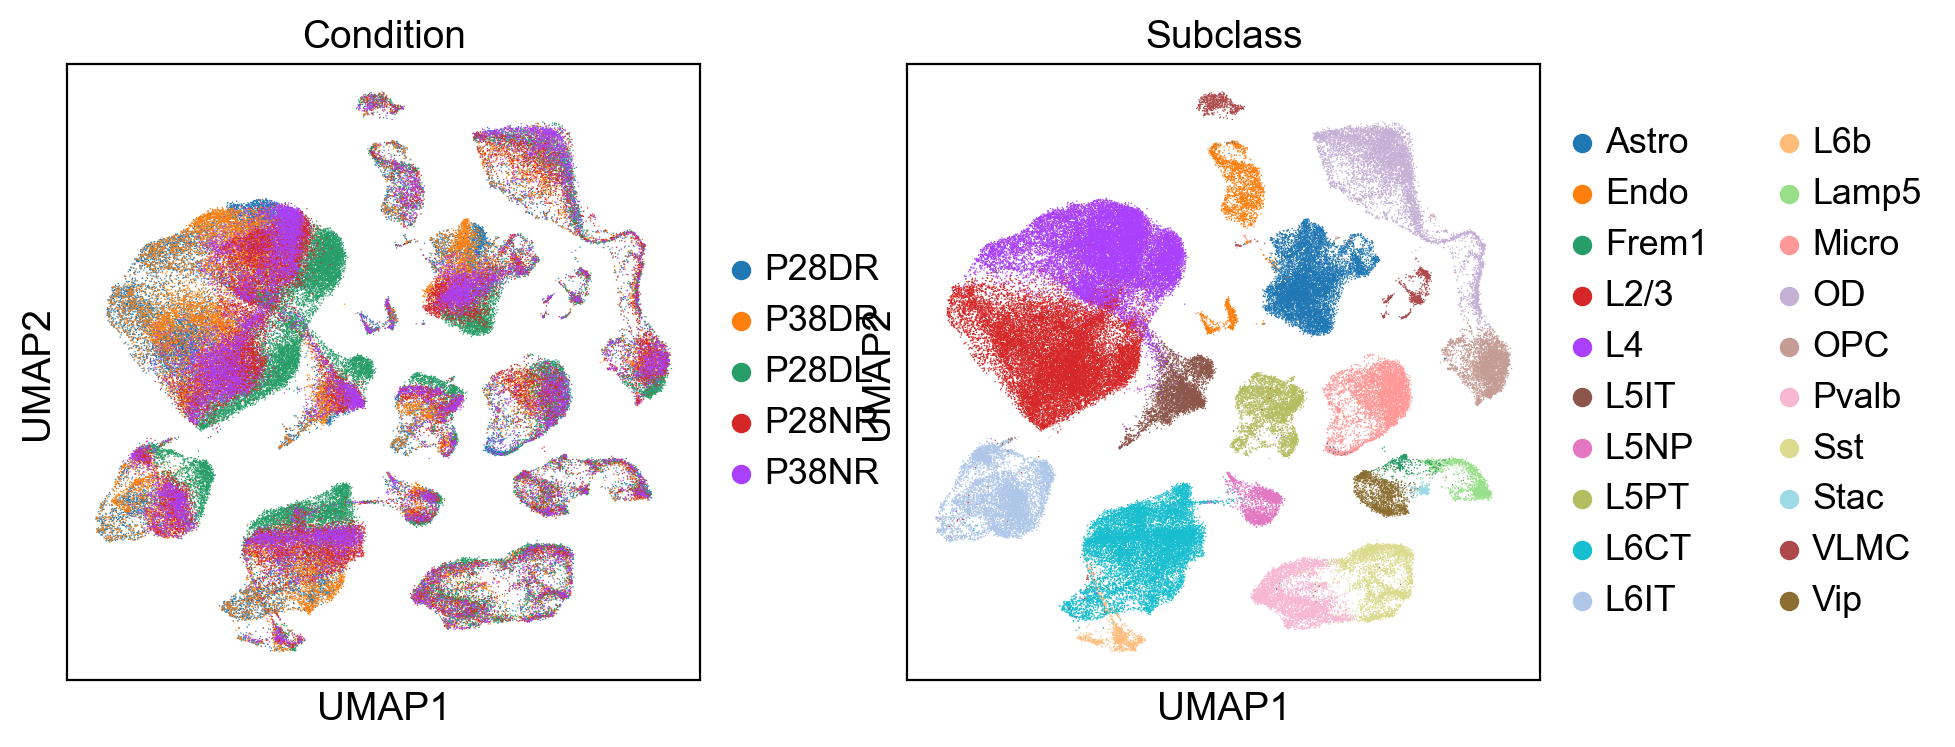

In [37]:
sc.pl.umap(adata, color=['Class'])
sc.pl.umap(adata, color=['Condition', 'Subclass'])

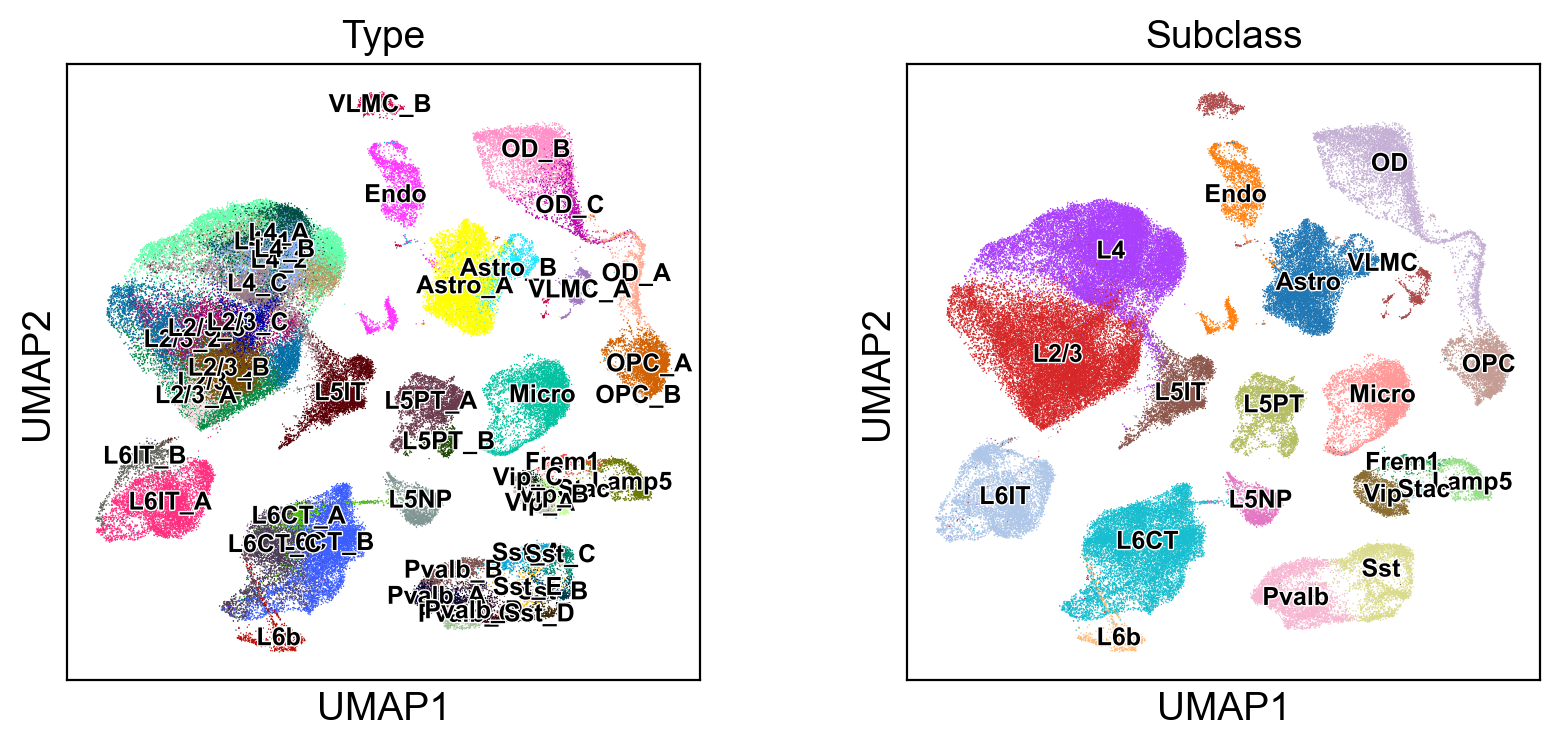

In [36]:
sc.pl.umap(adata, color=['Type', 'Subclass'], legend_loc='on data', legend_fontsize=9, legend_fontoutline=1)

## P28 DR

In [31]:
P28dr_all = adata[adata.obs.Condition=='P28DR',:]

In [32]:
P28dr_all.X = P28dr_all.raw.X.A

sc.pp.highly_variable_genes(P28dr_all, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs

sc.pp.scale(P28dr_all, max_value=10) #scale
sc.tl.pca(P28dr_all, svd_solver='arpack') #run PCA

Z = harmonize(P28dr_all.obsm['X_pca'], P28dr_all.obs, batch_key = 'sample')
P28dr_all.obsm['X_harmony'] = Z

sc.pp.neighbors(P28dr_all, n_neighbors=25, use_rep='X_harmony')


sc.tl.umap(P28dr_all)

extracting highly variable genes
    finished (0:00:04)


Trying to set attribute `.uns` of view, copying.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


... storing 'leiden' as categorical
... storing 'sample' as categorical
... storing 'layer' as categorical
... storing 'cluster' as categorical
... storing 'Type' as categorical
... storing 'Subclass' as categorical
... storing 'Class_broad' as categorical
... storing 'Age' as categorical
... storing 'subclass' as categorical
... storing 'sample_new' as categorical


Consider running `set_figure_params(dpi_save=...)`, which will adjust `matplotlib.rcParams['savefig.dpi']`


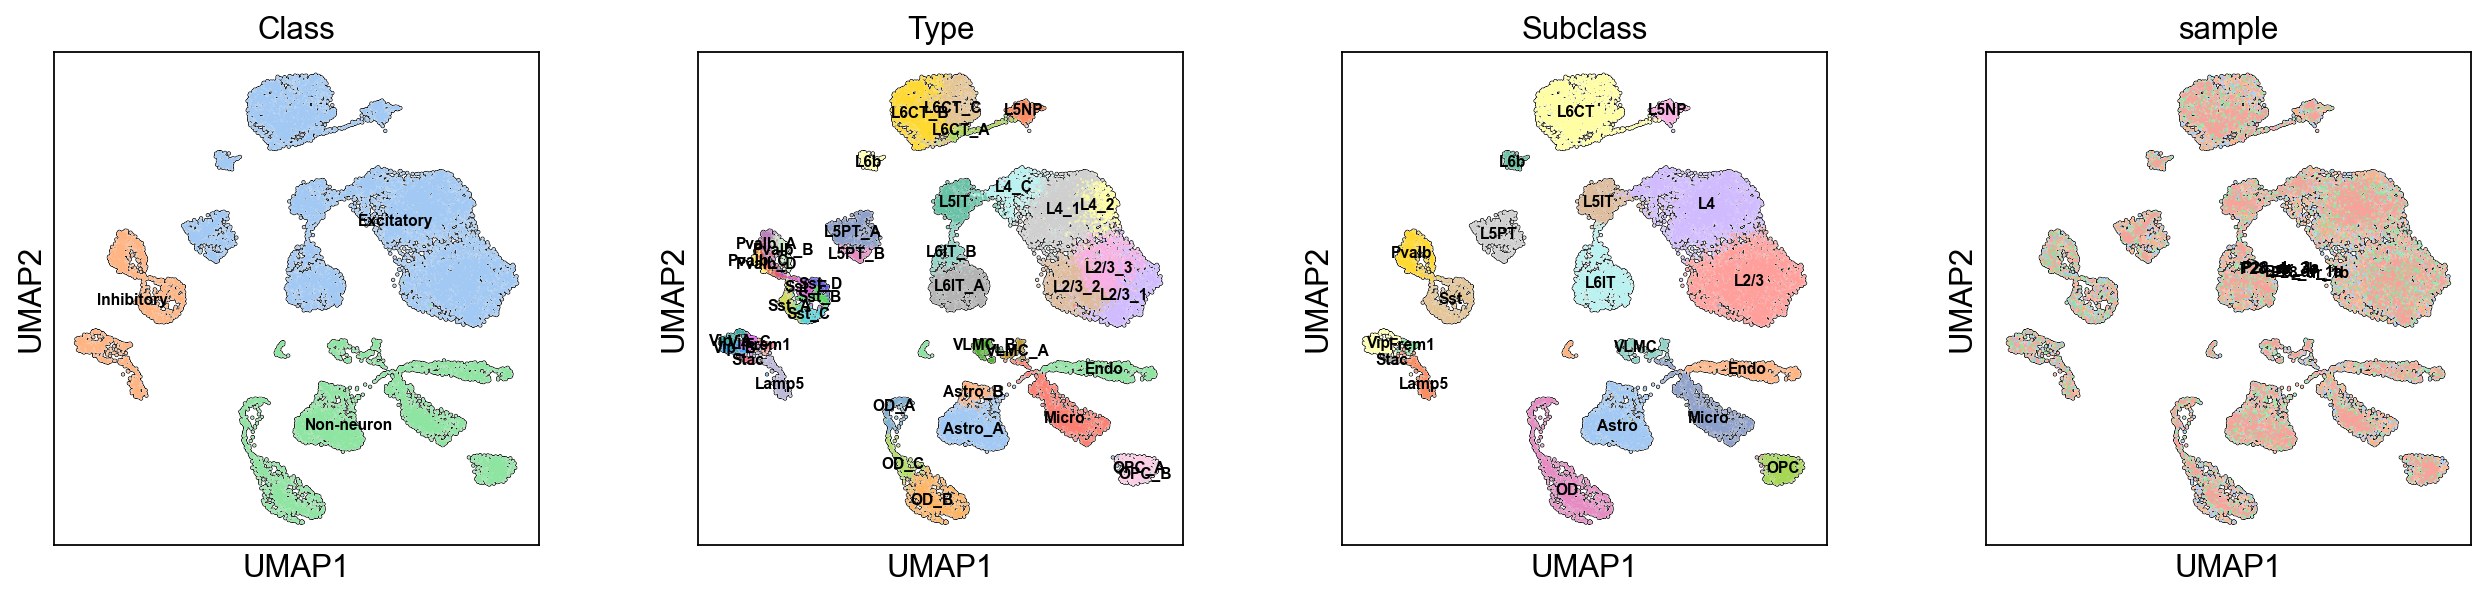

24817

In [33]:
type_cols = sns.color_palette('pastel').as_hex()+sns.color_palette('Set2').as_hex()+sns.color_palette('Set3').as_hex()+sns.color_palette('hls').as_hex()+sns.color_palette('husl').as_hex()
sc.set_figure_params(dpi_save=100)
sc.pl.umap(P28dr_all, color=['Class','Type', 'Subclass', 'sample'], legend_loc='on data', 
           legend_fontsize=7, palette=type_cols, legend_fontweight='semibold', add_outline=True,save='hi.pdf')
P28dr_all.shape[0]

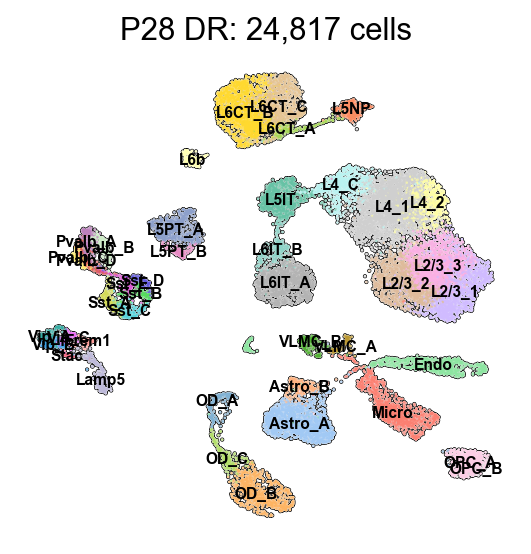

24817


In [226]:
type_cols = sns.color_palette('pastel').as_hex()+sns.color_palette('Set2').as_hex()+sns.color_palette('Set3').as_hex()+sns.color_palette('hls').as_hex()+sns.color_palette('husl').as_hex()
sc.set_figure_params(dpi_save=1000)
sc.pl.umap(P28dr_all, color=['Type',], legend_loc='on data', 
           legend_fontsize=7, palette=type_cols, 
           add_outline=True, title='P28 DR: ' + '24,817'  + ' cells', frameon=False,
           save='P28DR.pdf')
print(P28dr_all.shape[0])

## P38 DR

In [235]:
P38dr_all = adata[adata.obs.Condition=='P38DR',:]

P38dr_all.X = P38dr_all.raw.X.A

sc.pp.highly_variable_genes(P38dr_all, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs

sc.pp.scale(P38dr_all, max_value=10) #scale
sc.tl.pca(P38dr_all, svd_solver='arpack') #run PCA

Z = harmonize(P38dr_all.obsm['X_pca'], P38dr_all.obs, batch_key = 'sample')
P38dr_all.obsm['X_harmony'] = Z

sc.pp.neighbors(P38dr_all, n_neighbors=25, use_rep='X_harmony')


sc.tl.umap(P38dr_all)

extracting highly variable genes
    finished (0:00:04)


Trying to set attribute `.uns` of view, copying.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


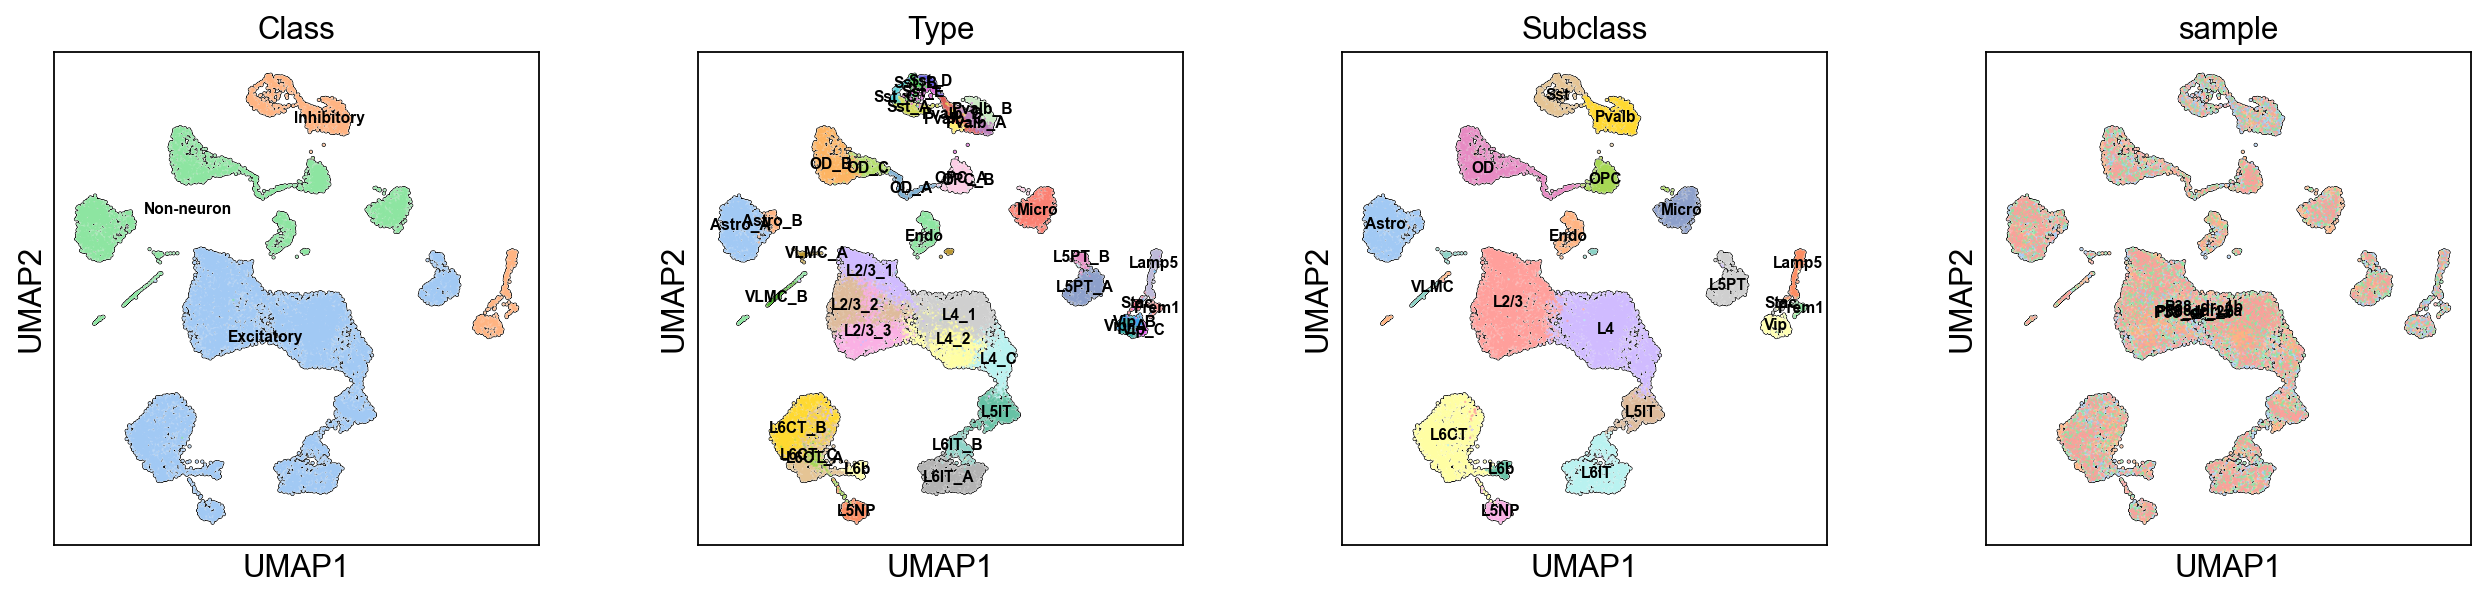

In [236]:
type_cols = sns.color_palette('pastel').as_hex()+sns.color_palette('Set2').as_hex()+sns.color_palette('Set3').as_hex()+sns.color_palette('hls').as_hex()+sns.color_palette('husl').as_hex()
sc.pl.umap(P38dr_all, color=['Class','Type', 'Subclass', 'sample'], legend_loc='on data', 
           legend_fontsize=7, palette=type_cols, legend_fontweight='semibold', add_outline=True)

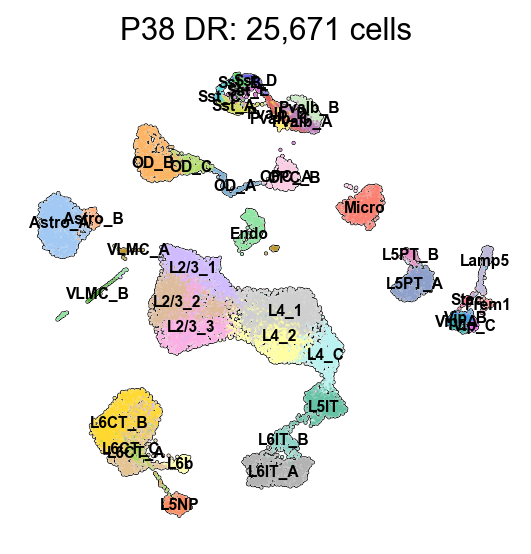

25671


In [241]:
sc.set_figure_params(dpi_save=1000)
sc.pl.umap(P38dr_all, color=['Type',], legend_loc='on data', 
           legend_fontsize=7, palette=type_cols, 
           add_outline=True, title='P38 DR: ' + '25,671'  + ' cells', frameon=False,
           save='P38DR.pdf')
print(P38dr_all.shape[0])

## P28 DL

In [240]:
P28dl_all = adata[adata.obs.Condition=='P28DL',:]

In [242]:
P28dl_all.X = P28dl_all.raw.X.A

sc.pp.highly_variable_genes(P28dl_all, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs

sc.pp.scale(P28dl_all, max_value=10) #scale
sc.tl.pca(P28dl_all, svd_solver='arpack') #run PCA

Z = harmonize(P28dl_all.obsm['X_pca'], P28dl_all.obs, batch_key = 'sample')
P28dl_all.obsm['X_harmony'] = Z

sc.pp.neighbors(P28dl_all, n_neighbors=25, use_rep='X_harmony')


sc.tl.umap(P28dl_all)

extracting highly variable genes
    finished (0:00:07)


Trying to set attribute `.uns` of view, copying.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)


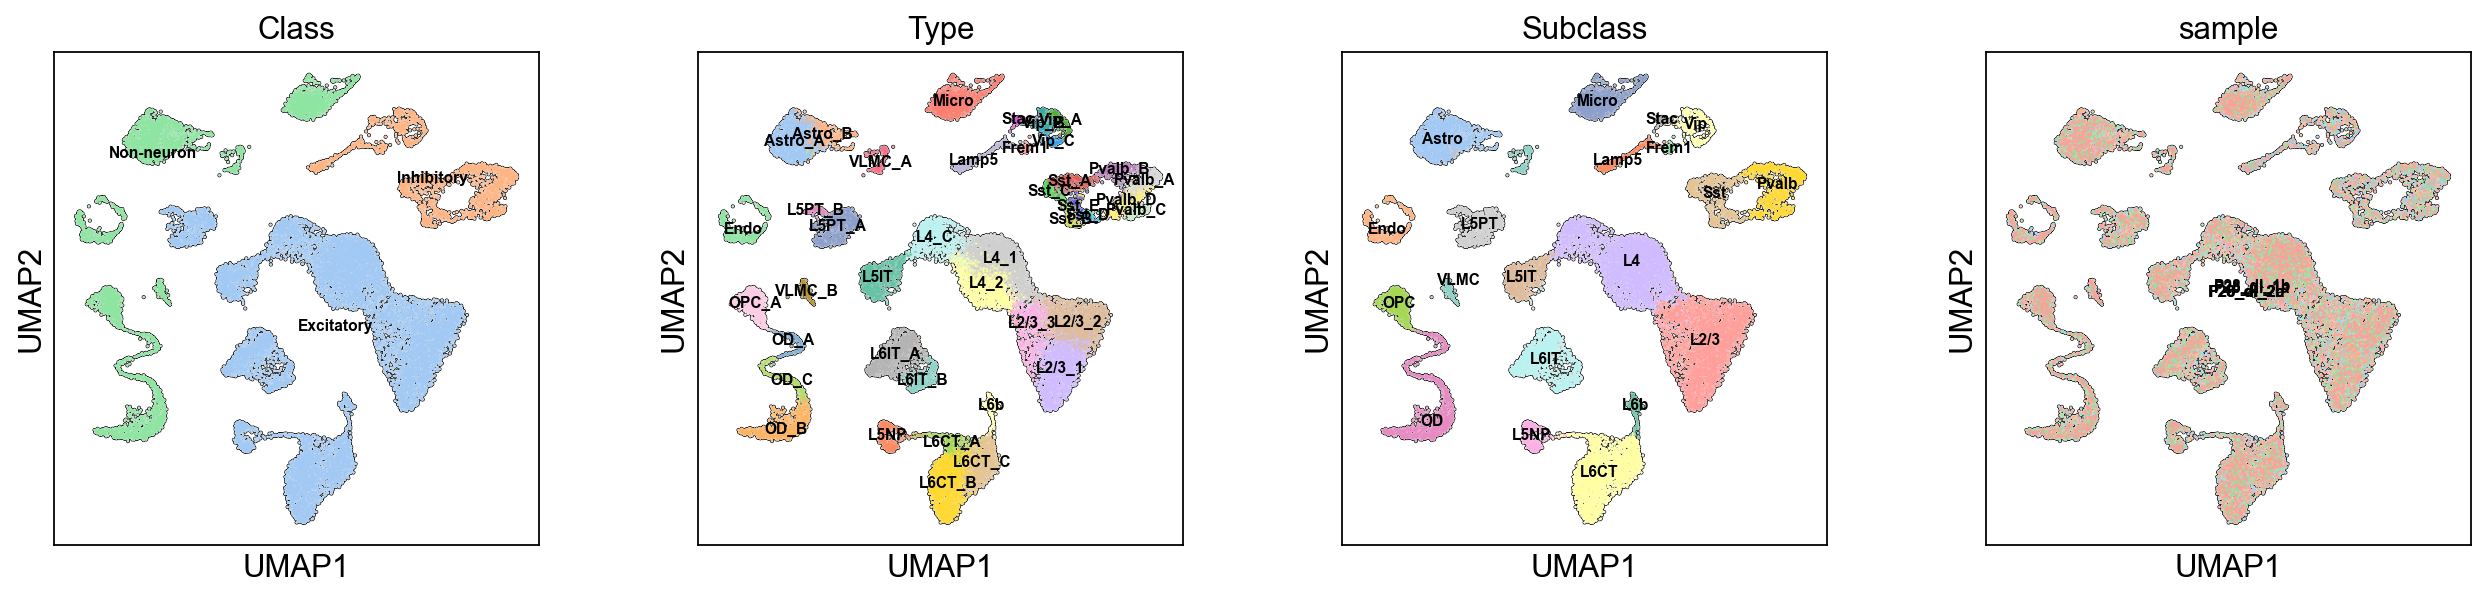

In [243]:
type_cols = sns.color_palette('pastel').as_hex()+sns.color_palette('Set2').as_hex()+sns.color_palette('Set3').as_hex()+sns.color_palette('hls').as_hex()+sns.color_palette('husl').as_hex()
sc.set_figure_params(dpi_save=100)
sc.pl.umap(P28dl_all, color=['Class','Type', 'Subclass', 'sample'], legend_loc='on data', 
           legend_fontsize=7, palette=type_cols, legend_fontweight='semibold', add_outline=True,save='hi.pdf')

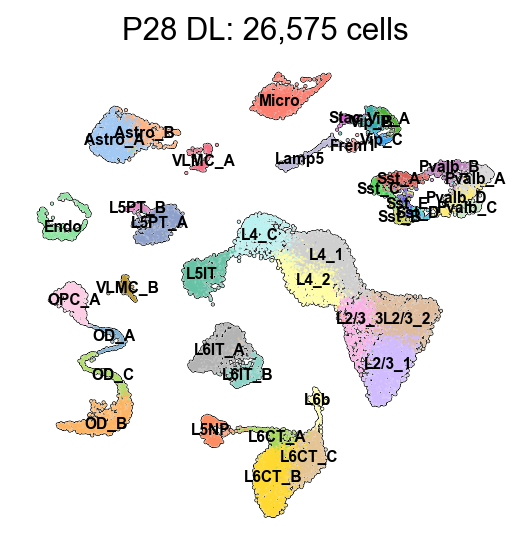

26575


In [246]:
type_cols = sns.color_palette('pastel').as_hex()+sns.color_palette('Set2').as_hex()+sns.color_palette('Set3').as_hex()+sns.color_palette('hls').as_hex()+sns.color_palette('husl').as_hex()
sc.set_figure_params(dpi_save=1000)
sc.pl.umap(P28dl_all, color=['Type',], legend_loc='on data', 
           legend_fontsize=7, palette=type_cols, 
           add_outline=True, title='P28 DL: ' + '26,575'  + ' cells', frameon=False,
           save='P28dl.pdf')
print(P28dl_all.shape[0])